<a href="https://colab.research.google.com/github/shivangini831-sys/FitPulse-Health-Anomaly-Detection-From-Fitness-Devices/blob/main/milestone_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

dt = datetime.now()
dt_utc = pytz.timezone("Asia/Kolkata").localize(dt).astimezone(pytz.UTC)

In [ ]:
hr = pd.read_csv('/content/drive/MyDrive/Fitpulse dataset/heart_rate.csv')
activity = pd.read_csv('/content/drive/MyDrive/Fitpulse dataset/dailyActivity_merged.csv')
sleep = pd.read_csv('/content/drive/MyDrive/Fitpulse dataset/sleepDay_merged.csv')
steps = pd.read_csv('/content/drive/MyDrive/Fitpulse dataset/dailySteps_merged.csv')
calories = pd.read_csv('/content/drive/MyDrive/Fitpulse dataset/dailyCalories_merged.csv')

In [ ]:
 hr.head() ,activity.head(), sleep.head(),steps.head(),calories.head()


(           Id                  Time  Value
 0  2022484408  4/12/2016 7:21:00 AM     97
 1  2022484408  4/12/2016 7:21:05 AM    102
 2  2022484408  4/12/2016 7:21:10 AM    105
 3  2022484408  4/12/2016 7:21:20 AM    103
 4  2022484408  4/12/2016 7:21:25 AM    101,
            Id ActivityDate  TotalSteps  TotalDistance  TrackerDistance  \
 0  1503960366    4/12/2016       13162           8.50             8.50   
 1  1503960366    4/13/2016       10735           6.97             6.97   
 2  1503960366    4/14/2016       10460           6.74             6.74   
 3  1503960366    4/15/2016        9762           6.28             6.28   
 4  1503960366    4/16/2016       12669           8.16             8.16   
 
    LoggedActivitiesDistance  VeryActiveDistance  ModeratelyActiveDistance  \
 0                       0.0                1.88                      0.55   
 1                       0.0                1.57                      0.69   
 2                       0.0                2.44 

In [ ]:
print(hr.columns)
print(activity.columns)
print(sleep.columns)
print(steps.columns)
print(calories.columns)


Index(['Id', 'Time', 'Value'], dtype='object')
Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')
Index(['Id', 'SleepDay', 'TotalSleepRecords', 'TotalMinutesAsleep',
       'TotalTimeInBed'],
      dtype='object')
Index(['Id', 'ActivityDay', 'StepTotal'], dtype='object')
Index(['Id', 'ActivityDay', 'Calories'], dtype='object')


In [ ]:
hr['Time'] = pd.to_datetime(hr['Time'], utc=True)


In [ ]:
activity['ActivityDate'] = pd.to_datetime(activity['ActivityDate'], utc=True)


In [ ]:
sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay'], utc=True)


/tmp/ipython-input-1450908408.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep['SleepDay'] = pd.to_datetime(sleep['SleepDay'], utc=True)


In [ ]:
hr.isnull().sum()
activity.isnull().sum()
sleep.isnull().sum()
steps.isnull().sum()
calories.isnull().sum()

,0
Id,0
ActivityDay,0
Calories,0


In [ ]:
hr['Value'] = hr['Value'].fillna(method='ffill')
activity.fillna(0, inplace=True)
sleep.fillna(0, inplace=True)
steps.fillna(0, inplace=True)
calories.fillna(0, inplace=True)

/tmp/ipython-input-2804110513.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hr['Value'] = hr['Value'].fillna(method='ffill')


In [ ]:
hr_1min = (
    hr
    .set_index('Time')
    .groupby('Id')['Value']
    .resample('1T')
    .mean()
    .reset_index()
)


/tmp/ipython-input-2839927264.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')


In [ ]:
hr_1min.rename(columns={'Value': 'HeartRate'}, inplace=True)


In [ ]:
activity_min = (
    activity_min
    .set_index('Time')
    .groupby('Id', as_index=False)
    .resample('1T')
    .ffill()
    .reset_index(drop=True)
)


/tmp/ipython-input-740488952.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('1T')


In [ ]:
activity_min.head()


,Id,TotalSteps,Calories
0,1503960366,13162,1985
1,1503960366,13162,1985
2,1503960366,13162,1985
3,1503960366,13162,1985
4,1503960366,13162,1985


In [ ]:
# Select columns
sleep_min = sleep[['Id', 'SleepDay', 'TotalMinutesAsleep']].copy()

# Convert to datetime
sleep_min['SleepDay'] = pd.to_datetime(sleep_min['SleepDay'], utc=True)

# Keep one row per user per day
sleep_min = sleep_min.groupby(['Id', 'SleepDay'], as_index=False).mean()

# Expand each day to 1-minute intervals
expanded_sleep = []

for _, row in sleep_min.iterrows():
    minutes = pd.date_range(
        start=row['SleepDay'],
        periods=1440,
        freq='1min',
        tz='UTC'
    )
    df_temp = pd.DataFrame({
        'Id': row['Id'],
        'Time': minutes,
        'TotalMinutesAsleep': row['TotalMinutesAsleep']
    })
    expanded_sleep.append(df_temp)

sleep_min = pd.concat(expanded_sleep, ignore_index=True)


In [ ]:
activity_min = activity[['Id', 'ActivityDate', 'TotalSteps', 'Calories']].copy()

activity_min['ActivityDate'] = pd.to_datetime(activity_min['ActivityDate'], utc=True)

# One row per user per day
activity_min = activity_min.groupby(['Id', 'ActivityDate'], as_index=False).sum()

expanded_activity = []

for _, row in activity_min.iterrows():
    minutes = pd.date_range(
        start=row['ActivityDate'],
        periods=1440,
        freq='1min',
        tz='UTC'
    )
    df_temp = pd.DataFrame({
        'Id': row['Id'],
        'Time': minutes,
        'TotalSteps': row['TotalSteps'],
        'Calories': row['Calories']
    })
    expanded_activity.append(df_temp)

activity_min = pd.concat(expanded_activity, ignore_index=True)


In [ ]:
# Select only required columns
steps_min = activity[['Id', 'ActivityDate', 'TotalSteps']].copy()

# Convert date to datetime (UTC)
steps_min['ActivityDate'] = pd.to_datetime(steps_min['ActivityDate'], utc=True)

# Ensure one row per user per day
steps_min = steps_min.groupby(['Id', 'ActivityDate'], as_index=False).sum()

# Expand each day to 1-minute intervals
expanded_steps = []

for _, row in steps_min.iterrows():
    minutes = pd.date_range(
        start=row['ActivityDate'],
        periods=1440,
        freq='1min',
        tz='UTC'
    )
    df_temp = pd.DataFrame({
        'Id': row['Id'],
        'Time': minutes,
        'Steps': row['TotalSteps']
    })
    expanded_steps.append(df_temp)

steps_min = pd.concat(expanded_steps, ignore_index=True)


In [ ]:
# Select required columns
calories_min = activity[['Id', 'ActivityDate', 'Calories']].copy()

# Convert date to datetime (UTC)
calories_min['ActivityDate'] = pd.to_datetime(calories_min['ActivityDate'], utc=True)

# Ensure one row per user per day
calories_min = calories_min.groupby(['Id', 'ActivityDate'], as_index=False).sum()

# Expand each day to 1-minute intervals
expanded_calories = []

for _, row in calories_min.iterrows():
    minutes = pd.date_range(
        start=row['ActivityDate'],
        periods=1440,
        freq='1min',
        tz='UTC'
    )
    df_temp = pd.DataFrame({
        'Id': row['Id'],
        'Time': minutes,
        'Calories': row['Calories']
    })
    expanded_calories.append(df_temp)

calories_min = pd.concat(expanded_calories, ignore_index=True)


In [ ]:
# Merge Heart Rate with Steps & Calories
final_df = hr_1min.merge(
    activity_min,      # contains Steps and Calories
    on=['Id', 'Time'],
    how='left'
)

# Merge Sleep data
final_df = final_df.merge(
    sleep_min,
    on=['Id', 'Time'],
    how='left'
)


In [ ]:
final_df = hr_1min.merge(activity_min, on=['Id', 'Time'], how='left')
final_df = final_df.merge(sleep_min, on=['Id', 'Time'], how='left')

In [ ]:
final_df.fillna(0, inplace=True)
final_df.sort_values(by=['Id', 'Time'], inplace=True)


In [ ]:
final_df.to_csv('/content/drive/MyDrive/Fitpulse dataset.csv',index=False)

In [ ]:
print(activity.shape)
activity.head()


(940, 15)


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-04-12 00:00:00+00:00,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,2016-04-13 00:00:00+00:00,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,2016-04-14 00:00:00+00:00,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,2016-04-15 00:00:00+00:00,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,2016-04-16 00:00:00+00:00,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [ ]:
print(activity.columns)


Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')


In [ ]:
# Select required columns
activity_min = activity[['Id', 'ActivityDate', 'TotalSteps', 'Calories']].copy()

# Convert to datetime
activity_min['ActivityDate'] = pd.to_datetime(activity_min['ActivityDate'], utc=True)

# Remove duplicates safely
activity_min = activity_min.drop_duplicates(subset=['Id', 'ActivityDate'])

print("Rows after cleaning:", activity_min.shape)

expanded_activity = []

for i, row in activity_min.iterrows():
    minutes = pd.date_range(
        start=row['ActivityDate'],
        periods=1440,
        freq='1min',
        tz='UTC'
    )

    df_temp = pd.DataFrame({
        'Id': row['Id'],
        'Time': minutes,
        'Steps': row['TotalSteps'],
        'Calories': row['Calories']
    })

    expanded_activity.append(df_temp)

# Combine all expanded data
activity_min = pd.concat(expanded_activity, ignore_index=True)

print("Final expanded shape:", activity_min.shape)
activity_min.head()


Rows after cleaning: (940, 4)
Final expanded shape: (1353600, 4)


,Id,Time,Steps,Calories
0,1503960366,2016-04-12 00:00:00+00:00,13162,1985
1,1503960366,2016-04-12 00:01:00+00:00,13162,1985
2,1503960366,2016-04-12 00:02:00+00:00,13162,1985
3,1503960366,2016-04-12 00:03:00+00:00,13162,1985
4,1503960366,2016-04-12 00:04:00+00:00,13162,1985


In [ ]:
final_df = hr_1min.merge(
    activity_min,      # Steps + Calories
    on=['Id', 'Time'],
    how='left'
)

final_df = final_df.merge(
    sleep_min,         # Sleep
    on=['Id', 'Time'],
    how='left'
)


In [ ]:
final_df['Steps'] = final_df['Steps'].fillna(0)
final_df['Calories'] = final_df['Calories'].fillna(0)
final_df['TotalMinutesAsleep'] = final_df['TotalMinutesAsleep'].fillna(0)


In [ ]:
final_df['Activity'] = final_df['Steps'].apply(
    lambda x: 'Active' if x > 0 else 'Inactive'
)


In [ ]:
final_df.sort_values(by=['Id', 'Time'], inplace=True)
final_df.head()


,Id,Time,HeartRate,Steps,Calories,TotalMinutesAsleep,Activity
0,2022484408,2016-04-12 07:21:00+00:00,101.600000,11875,2390,0.0,Active
1,2022484408,2016-04-12 07:22:00+00:00,87.888889,11875,2390,0.0,Active
2,2022484408,2016-04-12 07:23:00+00:00,58.000000,11875,2390,0.0,Active
3,2022484408,2016-04-12 07:24:00+00:00,58.000000,11875,2390,0.0,Active
4,2022484408,2016-04-12 07:25:00+00:00,56.777778,11875,2390,0.0,Active


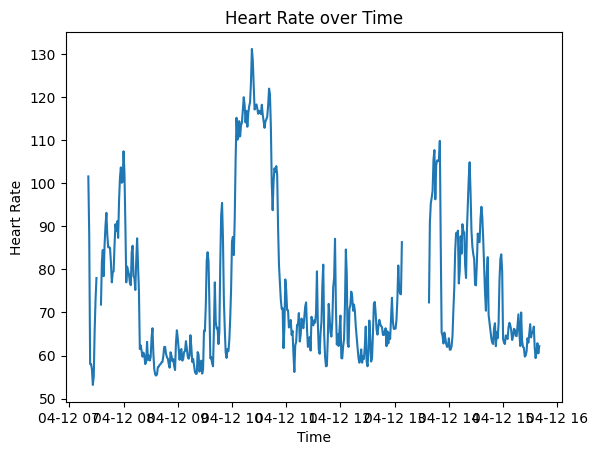

In [ ]:
import matplotlib.pyplot as plt

sample_id = final_df['Id'].iloc[0]
sample_df = final_df[final_df['Id'] == sample_id].head(500)

plt.figure()
plt.plot(sample_df['Time'], sample_df['HeartRate'])
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title('Heart Rate over Time')
plt.show()


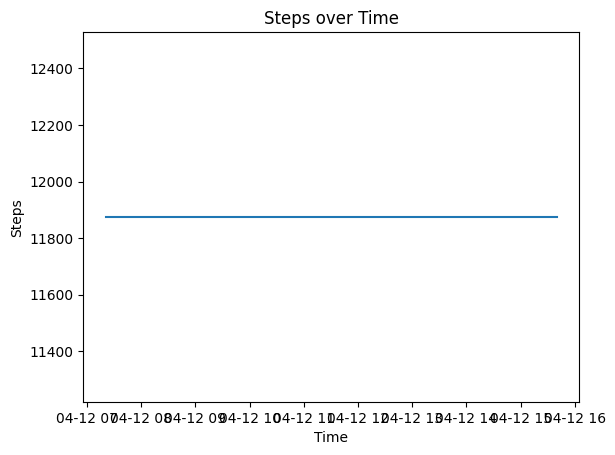

In [ ]:
plt.figure()
plt.plot(sample_df['Time'], sample_df['Steps'])
plt.xlabel('Time')
plt.ylabel('Steps')
plt.title('Steps over Time')
plt.show()


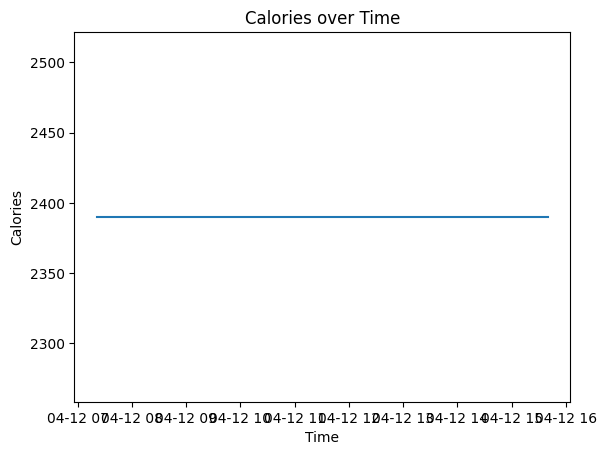

In [ ]:
plt.figure()
plt.plot(sample_df['Time'], sample_df['Calories'])
plt.xlabel('Time')
plt.ylabel('Calories')
plt.title('Calories over Time')
plt.show()


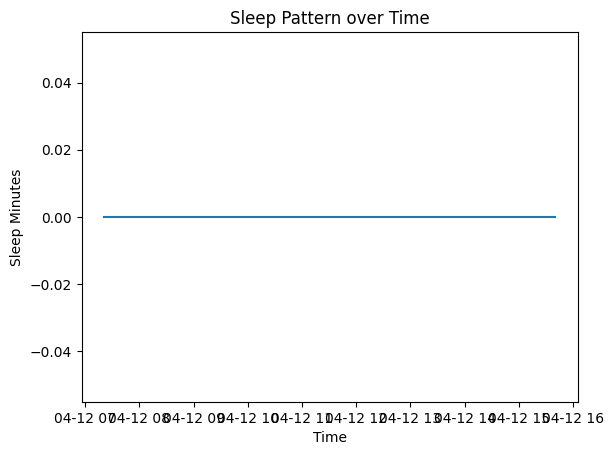

In [ ]:
plt.figure()
plt.plot(sample_df['Time'], sample_df['TotalMinutesAsleep'])
plt.xlabel('Time')
plt.ylabel('Sleep Minutes')
plt.title('Sleep Pattern over Time')
plt.show()


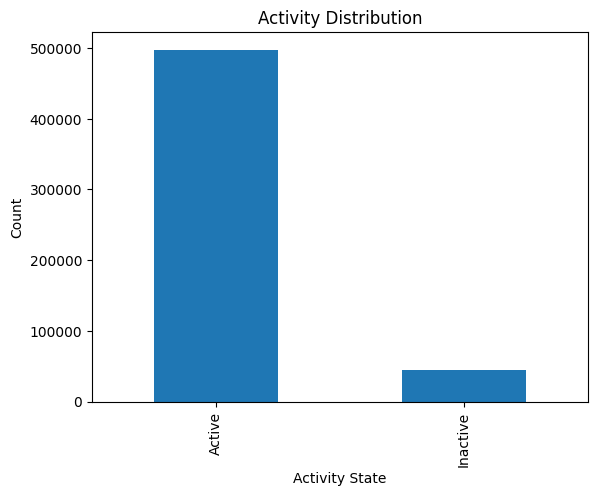

In [ ]:
final_df['Activity'].value_counts().plot(kind='bar')
plt.xlabel('Activity State')
plt.ylabel('Count')
plt.title('Activity Distribution')
plt.show()
